# Testing the impact of different W computation methods in ariane

In [1]:
#import required libraries
import datetime
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt


%matplotlib inline
import pandas as pd
import cmocean as cm
import netCDF4 as nc
from cartopy import crs, feature
from salishsea_tools import geo_tools

## Quantitative Compare

In [3]:
def get_data(section, starttime, endtime):
    final_section = mydata.variables['final_section'][:]
    final_transport = mydata.variables['final_transp'][:]
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

In [27]:
starttime = 1
endtime = 720
sections = [0,2,3,4,5,6,7,8]

In [30]:
mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/W_test/neww_01mar19/ariane_positions_quantitative.nc')

new = np.zeros(8)

for i in range(len(new)):
    if sections[i] == 8:
        new[i] = sum(mydata.init_transp.values)/(endtime) - sum(new[:-1])
    else:
        new[i] = get_data(sections[i], starttime, endtime)

In [32]:
mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/W_test/oldw_01mar19/ariane_positions_quantitative.nc')

old = np.zeros(8)

for i in range(len(old)):
    if sections[i] == 8:
        old[i] = sum(mydata.init_transp.values)/(endtime) - sum(old[:-1])
    else:
        old[i] = get_data(sections[i], starttime, endtime)

In [33]:
mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01mar19/ariane_positions_quantitative.nc')

non = np.zeros(8)

for i in range(len(non)):
    if sections[i] == 8:
        non[i] = sum(mydata.init_transp.values)/(endtime) - sum(non[:-1])
    else:
        non[i] = get_data(sections[i], starttime, endtime)

<ipython-input-46-4618e85a6935>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['_','Meander','Admiralty','Deception','Rosario','San Juan','Haro','Surface','Lost'])


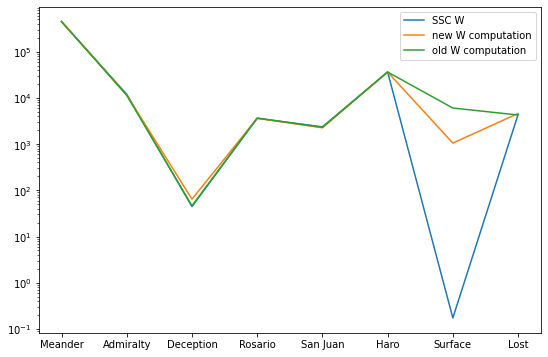

In [46]:
fig, ax = plt.subplots(1,1,figsize=(9,6))
ax.plot(non,label='SSC W')
ax.plot(new,label='new W computation')
ax.plot(old,label='old W computation')
ax.set_yscale('log')
ax.set_xticklabels(['_','Meander','Admiralty','Deception','Rosario','San Juan','Haro','Surface','Lost'])
ax.legend()


<ipython-input-48-2cf100efa15b>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['_','Admiralty','Deception','Rosario','San Juan','Haro','Surface','Lost'])


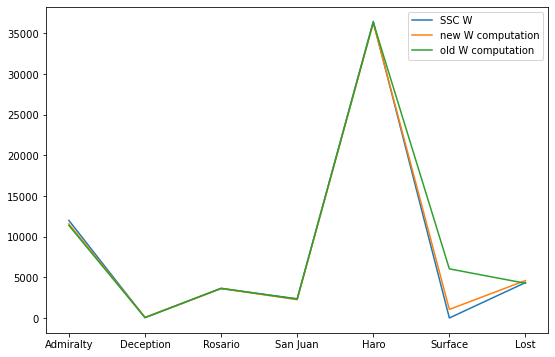

In [48]:
fig, ax = plt.subplots(1,1,figsize=(9,6))
ax.plot(non[1:],label='SSC W')
ax.plot(new[1:],label='new W computation')
ax.plot(old[1:],label='old W computation')
# ax.set_yscale('log')
ax.set_xticklabels(['_','Admiralty','Deception','Rosario','San Juan','Haro','Surface','Lost'])
ax.legend()

## Qualitative Compare

In [2]:
mesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

In [3]:
def plt_qual_2D(file, ax):
    
    n = 14 #number of particles being tracked
    
    # Bathymetry
    c = ax.contourf(
    mesh.nav_lon, mesh.nav_lat, mesh.mbathy[0,:,:]*10, levels=np.arange(0, 500.1, 5),
    cmap=cm.cm.deep, extend='max',zorder=0,
    )
    
    # "Mapping"
    ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
    ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k',zorder=2)
    ax.set_xlim([-126.7, -123.7])
    ax.set_ylim([47.5, 49.5])
    ax.set_aspect(1/np.sin(np.deg2rad(49)))
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
#     ax.set_title(month, fontsize=16)
    
    # Particle trajectories and depth
    im = ax.scatter(file.traj_lon,file.traj_lat, c=file.traj_depth, vmax=0, vmin=-100, cmap=cm.cm.solar, s=10,zorder=3)
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
    ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s', zorder=4) # start location
    
    # End locations
    last_point= [pd.DataFrame(file.traj_lat[:,i]).last_valid_index() for i in range(n)]
    for i in range(n):
        ax.scatter(file.traj_lon[last_point[i],i],file.traj_lat[last_point[i],i],color='r',marker='*', zorder=4)

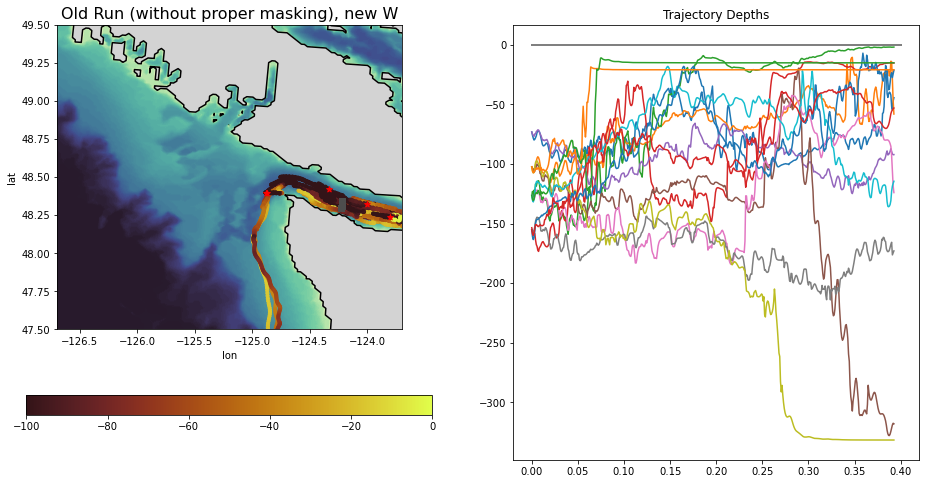

In [6]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/backward_30apr17/ariane_trajectories_qualitative.nc')
plt_qual_2D(file, ax[0])
ax[0].set_title("Old Run (without proper masking), new W", fontsize=16)

n=14
for i in range(n):
    ax[1].plot(file.traj_time[:,i], file.traj_depth[:,i],label='trajectory '+str(i+1))
#     ax[0,0].legend()
    ax[1].set_title('Trajectory Depths')
    ax[1].plot([0.00,0.40],[0,0],'grey')

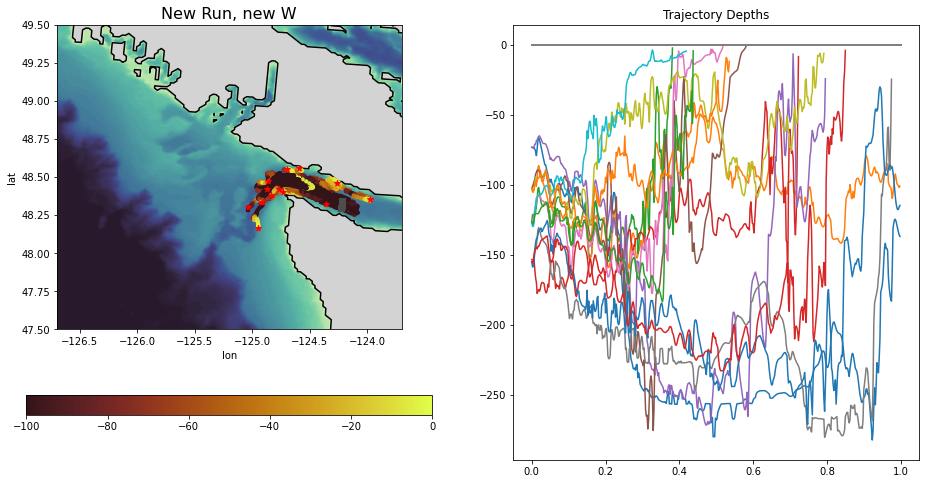

In [7]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/new_backward_30apr17/ariane_trajectories_qualitative.nc')
plt_qual_2D(file, ax[0])
ax[0].set_title("New Run, new W", fontsize=16)

n=14
for i in range(n):
    ax[1].plot(file.traj_time[:,i], file.traj_depth[:,i],label='trajectory '+str(i+1))
#     ax[0,0].legend()
    ax[1].set_title('Trajectory Depths')
    ax[1].plot([0.00,1],[0,0],'grey')

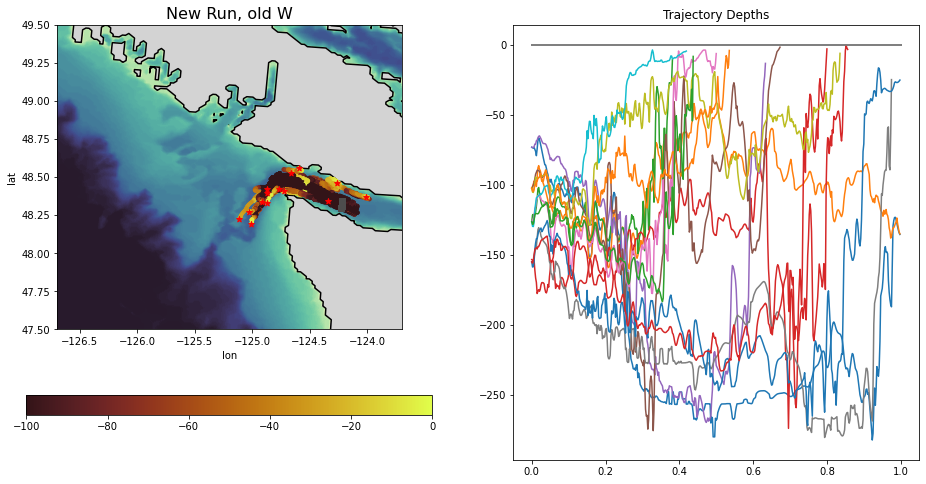

In [4]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/new_oldw_backward_30apr17/ariane_trajectories_qualitative.nc')
plt_qual_2D(file, ax[0])
ax[0].set_title("New Run, old W", fontsize=16)

n=14
for i in range(n):
    ax[1].plot(file.traj_time[:,i], file.traj_depth[:,i],label='trajectory '+str(i+1))
#     ax[0,0].legend()
    ax[1].set_title('Trajectory Depths')
    ax[1].plot([0.00,1],[0,0],'grey')

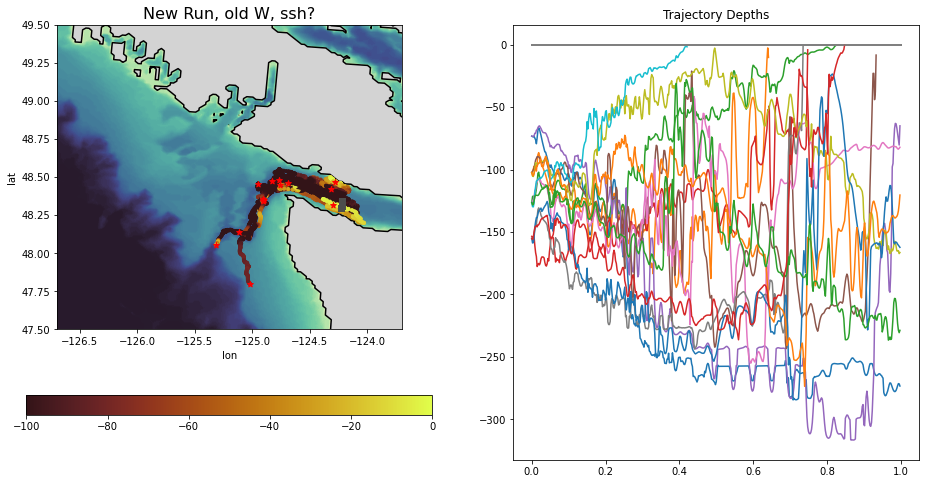

In [5]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/back_30apr17/ariane_trajectories_qualitative.nc')
plt_qual_2D(file, ax[0])
ax[0].set_title("New Run, old W, ssh?", fontsize=16)

n=14
for i in range(n):
    ax[1].plot(file.traj_time[:,i], file.traj_depth[:,i],label='trajectory '+str(i+1))
#     ax[0,0].legend()
    ax[1].set_title('Trajectory Depths')
    ax[1].plot([0.00,1],[0,0],'grey')

Text(0.5, 1.0, 'April 2017')

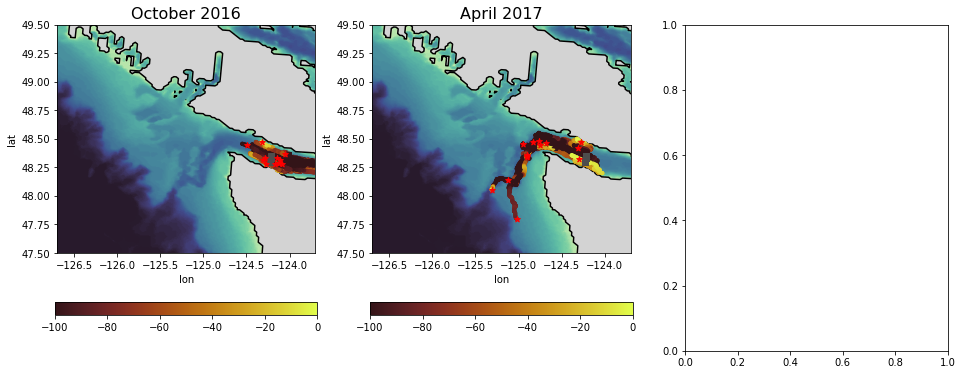

In [9]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/back_30oct16/ariane_trajectories_qualitative.nc')
plt_qual_2D(file, ax[0])
ax[0].set_title("October 2016", fontsize=16)

file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/back_30apr17/ariane_trajectories_qualitative.nc')
plt_qual_2D(file, ax[1])
ax[1].set_title("April 2017", fontsize=16)

Text(0, 0.5, 'lat')

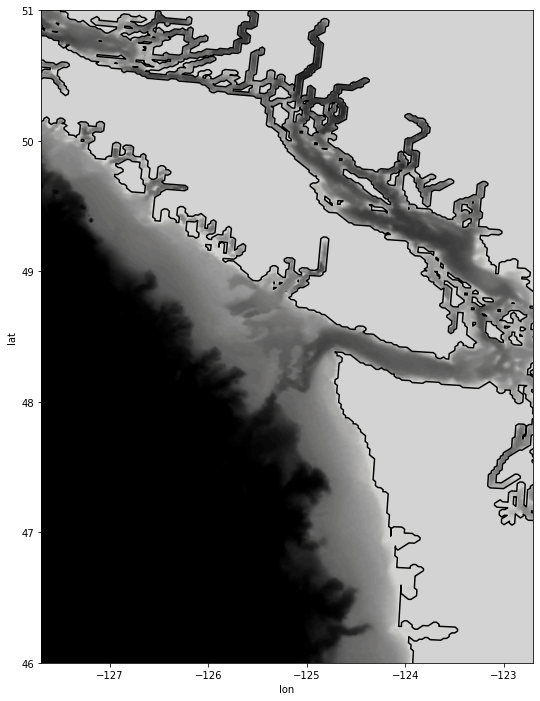

In [18]:
fig, ax = plt.subplots(figsize=(15,12))

# Bathymetry
c = ax.contourf(
mesh.nav_lon, mesh.nav_lat, mesh.mbathy[0,:,:]*10, levels=np.arange(0, 500.1, 5),
cmap=cm.cm.gray_r, extend='max',zorder=0,
)
    
# "Mapping"
ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k',zorder=2)
ax.set_xlim([-127.7, -122.7])
ax.set_ylim([46, 51])
ax.set_aspect(1/np.sin(np.deg2rad(49)))
ax.set_xlabel('lon')
ax.set_ylabel('lat')

In [16]:
def plt_qual_salt(file, ax):
    
    n = 14 #number of particles being tracked
    
    # Bathymetry
    c = ax.contourf(
    mesh.nav_lon, mesh.nav_lat, mesh.mbathy[0,:,:]*10, levels=np.arange(0, 500.1, 5),
    cmap=cm.cm.deep, extend='max',zorder=0,
    )
    
    # "Mapping"
    ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
    ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k',zorder=2)
    ax.set_xlim([-126.7, -123.7])
    ax.set_ylim([47.5, 49.5])
    ax.set_aspect(1/np.sin(np.deg2rad(49)))
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
#     ax.set_title(month, fontsize=16)
    
    # Particle trajectories and depth
    im = ax.scatter(file.traj_lon,file.traj_lat, c=file.traj_salt, vmax=34, vmin=30, cmap=cm.cm.amp, s=10,zorder=3)
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
    ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s', zorder=4) # start location
    
    # End locations
    last_point= [pd.DataFrame(file.traj_lat[:,i]).last_valid_index() for i in range(n)]
    for i in range(n):
        ax.scatter(file.traj_lon[last_point[i],i],file.traj_lat[last_point[i],i],color='r',marker='*', zorder=4)

Text(0.5, 1.0, 'April 2017')

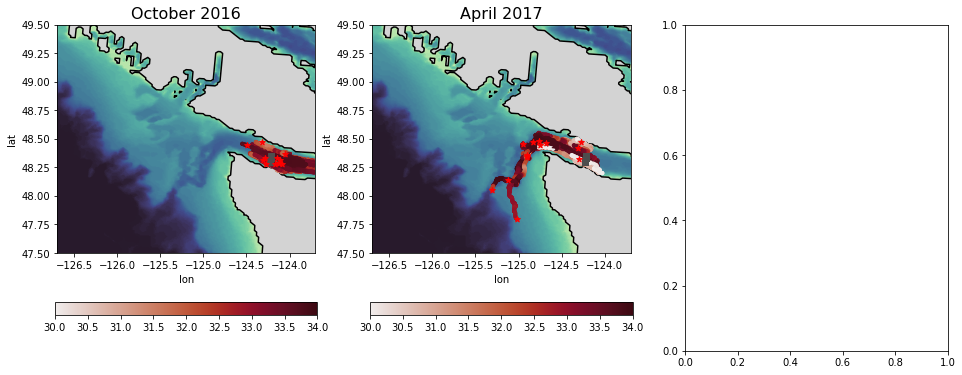

In [17]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/back_30oct16/ariane_trajectories_qualitative.nc')
plt_qual_salt(file, ax[0])
ax[0].set_title("October 2016", fontsize=16)

file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/back_30apr17/ariane_trajectories_qualitative.nc')
plt_qual_salt(file, ax[1])
ax[1].set_title("April 2017", fontsize=16)

# old W, new U and V calc, with ssh looks best ot me!!
#### go ahead with this for runs for CMOS presentation

In [9]:
# lets do some quick ssh check in here bc i'm too lazy to make a new file for this or to learn how to do it more efficialty in linux

In [12]:
zos = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/2017010800/BC12_1h_grid_T_2D_20170106_20170106.nc').zos

In [14]:
u = xr.open_dataset('/ocean/rbeutel/data/201701/U_new_20170106.nc').vozocrtx

In [20]:
u

<xarray.DataArray 'vozocrtx' (time_counter: 24, depthu: 75, y: 1020, x: 714)>
[1310904000 values with dtype=float64]
Coordinates:
  * depthu        (depthu) float32 0.5075 1.558 2.669 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) datetime64[ns] 2017-01-06T01:00:00 ... 2017-...
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
Dimensions without coordinates: y, x

In [19]:
zos

<xarray.DataArray 'zos' (time_counter: 24, y: 1020, x: 714)>
[17478720 values with dtype=float32]
Coordinates:
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
  * time_counter  (time_counter) datetime64[ns] 2017-01-06T01:00:00 ... 2017-...
    time_instant  (time_counter) datetime64[ns] 2017-01-06T01:00:00 ... 2017-...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea_surface_height_above_geoid
    units:               m
    online_operation:    instant
    interval_operation:  60 s
    interval_write:      1 h
    cell_methods:        time: point (interval: 60 s)